<a href="https://colab.research.google.com/github/timosachsenberg/EuBIC2026/blob/main/notebooks/EUBIC_Task3_Quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [252]:
# Install dependencies (for Google Colab)
!pip install -q pyopenms>=3.5.0 pyopenms-viz>=1.0.0

# Notebook 3 – Quantification

> **Prerequisites**: This notebook builds on [Notebook 1 - From Proteins to Spectra](EUBIC_Task1_Peaks.ipynb) and [Notebook 2 - Peptide Identification](EUBIC_Task2_ID.ipynb). You should be familiar with MS1 spectra, peptide identification, and PSMs.

In this tutorial, we demonstrate a complete feature detection and annotation workflow using the OpenMS implementation of Biosaur2, an isotope-aware feature detection algorithm.

**What is quantification?** In proteomics, quantification refers to measuring the abundance of peptides or proteins in a sample. This is typically done by integrating the MS1 signal intensity over the elution time of each peptide, producing a value proportional to the amount of that peptide present.

**What is feature detection?** Feature detection groups related peaks across multiple spectra into a single entity called a "feature". Unlike peak picking (which finds peaks in individual spectra), feature detection tracks signals across retention time, recognizing that the same peptide ion produces peaks in consecutive scans as it elutes from the LC column.

In this notebook we will:

1. **Apply the Biosaur2 algorithm to detect isotope-resolved features from mzML data.**

2. **Annotate the feature map with peptide identifications.**

3. **Visually inspect detected features in retention time–m/z–intensity space.**

---

<details>
<summary><b>Quick Reference: Key Terms Used in This Notebook</b></summary>

| Term | Definition |
|------|------------|
| **Feature** | A detected peptide signal tracked across multiple MS1 scans |
| **Centroid** | Intensity-weighted center of a peak (single m/z value) |
| **Apex** | Point of maximum intensity during elution (peak top) |
| **Integrated intensity** | Area under the curve - sum of intensities across elution |
| **FeatureMap** | OpenMS container holding all detected features |
| **IDMapper** | Tool linking MS2 identifications to MS1 features |
| **RT tolerance** | Maximum allowed difference in retention time (seconds) when matching an MS2 identification to an MS1 feature |
| **m/z tolerance** | Maximum allowed difference in mass-to-charge ratio (often in ppm) when matching an MS2 identification to an MS1 feature |

</details>

<details>
<summary><b>How Does Feature Detection Differ From Peak Picking?</b></summary>

**Peak Picking** (per-spectrum):

Peak picking converts the raw signal intensities recorded by the ion detector (profile data) into discrete m/z values (centroided data). Each continuous peak profile is reduced to a single m/z position representing its intensity-weighted center.

**Feature Detection** (cross-spectrum):

![Feature detection illustration](https://raw.githubusercontent.com/timosachsenberg/EuBIC2026/main/notebooks/images/feature.png)

*A feature represents a peptide ion tracked across retention time. The feature boundaries are defined by the m/z range spanning the isotope pattern (monoisotopic peak plus heavier isotopes) and the RT range spanning the chromatographic elution profile.*

Feature detection provides:
- Single quantitative value per peptide ion (i.e., per peptide observed with a specific charge state)
- Charge state inference from isotope pattern
- Noise filtering (signals must persist over time)
- Ready for quantitative comparison

</details>

<details>
<summary><b>Why Use Integrated Intensity for Quantification?</b></summary>

Integrating the signal over the entire elution profile (area under the curve) rather than using a single intensity value (e.g., apex intensity) provides more robust and comparable quantification across samples.

**The key advantage**: Slight differences in chromatography between experiments can cause peak broadening or sharpening, changing the apex intensity. However, the integrated area remains constant because the same total amount of analyte elutes - it's just spread over a wider or narrower time window.

![Peak broadening illustration](https://raw.githubusercontent.com/timosachsenberg/EuBIC2026/main/notebooks/images/peak_broadening.png)

Both samples contain the same peptide amount, but apex intensities differ. Integrated intensities correctly show equal abundance.

</details>

<details>
<summary><b>Common Errors and How to Fix Them</b></summary>

**1. FileNotFoundError: File not found**
```python
# Error: FileNotFoundError: [Errno 2] No such file or directory: 'UPS1_5min.mzML'
```
**Cause**: The data file wasn't downloaded or the path is wrong.

**Fix**: Make sure the download cell ran successfully, or check the filename:
```python
import os
print(os.listdir("."))  # List files in current directory
```

---

**2. Empty FeatureMap (0 features detected)**
```python
# Output: Detected 0 features
```
**Cause**: Usually means the input data has issues.

**Fix**: Check that your mzML file:
- Contains MS1 spectra: `sum(1 for s in exp if s.getMSLevel() == 1)`
- Has centroided data (not profile mode)
- Is not corrupted: try reloading with `exp = oms.MSExperiment(); oms.MzMLFile().load("file.mzML", exp)`

---

**3. No identifications mapped (0 features with peptide IDs)**
```python
# Output: Features with peptide IDs: 0 / 7500
```
**Cause**: IDMapper tolerances too tight, or RT/m/z mismatch between files.

**Fix**:
- Check that the idXML file loaded correctly: `print(len(peptide_ids))`
- Increase tolerances: `params.setValue("rt_tolerance", 20.0)`
- Verify the idXML comes from the same mzML file

---

**4. ModuleNotFoundError: No module named 'pyopenms'**
```python
# Error: ModuleNotFoundError: No module named 'pyopenms'
```
**Fix**: Install the package:
```python
!pip install pyopenms>=3.5.0
```

---

**5. Visualization not showing (blank output)**

**Cause**: Plotly renderer not configured for your environment.

**Fix for Jupyter**:
```python
import plotly.io as pio
pio.renderers.default = "notebook"  # or "jupyterlab" or "colab"
```

</details>

<details>
<summary><b>New to interactive Plotly visualizations?</b></summary>

This notebook uses **Plotly** for interactive visualizations. Here's how to use them:

**Navigation controls:**
- **Zoom**: Click and drag to select a region
- **Pan**: Hold Shift + click and drag
- **Reset**: Double-click to reset view
- **Hover**: Move mouse over points to see details

**Toolbar (top-right):**
- 📷 Download as PNG
- 🔍 Zoom/Pan toggle
- ↩️ Reset axes
- 🏠 Reset to original view

**Tips for exploration:**
- Start zoomed out to see overall patterns
- Zoom into regions of interest
- Use hover info to identify specific features

</details>

In [253]:

%matplotlib inline
import os
import pyopenms as oms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
print("pyOpenMS version:", oms.__version__)


pyOpenMS version: 3.5.0


In [254]:
# Download mzML and idXML files from course repository
if not os.path.exists("UPS1_5min.mzML"):
    !wget -q -O "UPS1_5min.mzML" https://raw.githubusercontent.com/timosachsenberg/EuBIC2026/main/data/UPS1_5min.mzML

if not os.path.exists("UPS1_5min.idXML"):
    !wget -q -O "UPS1_5min.idXML" https://raw.githubusercontent.com/timosachsenberg/EuBIC2026/main/data/UPS1_5min.idXML

# Load mzML file into MSExperiment
exp = oms.MSExperiment()
oms.MzMLFile().load("UPS1_5min.mzML", exp)

print(f"Loaded {exp.size()} spectra from UPS1_5min.mzML")

Loaded 2043 spectra from UPS1_5min.mzML


**File formats used:**

| Format | Description |
|--------|-------------|
| **mzML** | Open XML format for mass spectrometry raw data (spectra with m/z and intensity values) |
| **idXML** | OpenMS XML format storing peptide and protein identification results from database searches |
| **featureXML** | OpenMS XML format storing detected features with quantitative properties (RT, m/z, intensity, charge, boundaries) |

# 1. Apply the Biosaur2 algorithm.

**Biosaur2** ([Ivanov et al., 2024](https://doi.org/10.1021/acs.jproteome.4c00513)) is an isotope-aware feature detection method that identifies peptide features by clustering peaks across retention time and evaluating their isotopic patterns and charge state consistency. This strategy enables reliable discrimination between true peptide signals and background noise, particularly in complex LC–MS datasets. The algorithm has been implemented in OpenMS and is available through pyOpenMS as `Biosaur2Algorithm`.

Each detected feature represents an aggregated MS1 signal characterized by a centroid mass-to-charge ratio, a retention time apex, an integrated intensity, and an inferred charge state.

The implementation initializes a `Biosaur2Algorithm()` instance and provides the experimental data as an `MSExperiment` loaded from the mzML file. Feature detection executes with default parameters, yielding a FeatureMap object containing all detected features.

<details>
<summary><b>Deep Dive: How Does Biosaur2 Work?</b></summary>

![Biosaur2 algorithm overview](https://raw.githubusercontent.com/timosachsenberg/EuBIC2026/main/notebooks/images/biosaur_overview.jpg)

**Biosaur2's Approach to Feature Detection:**

1. **Peak Detection**: Find centroided peaks in each MS1 spectrum

2. **Isotope Pattern Recognition**: Look for characteristic isotope patterns where peaks are spaced by 1/z (charge state):

![Isotope pattern example](https://raw.githubusercontent.com/timosachsenberg/EuBIC2026/main/notebooks/images/DFPIANGER_isoDistribution.png)

3. **Charge State Inference**: Use isotope spacing to determine charge
   - 1.0 m/z spacing → +1
   - 0.5 m/z spacing → +2
   - 0.33 m/z spacing → +3

4. **RT Tracking**: Follow the same isotope pattern across consecutive scans to build the elution profile:

![RT tracking illustration](https://raw.githubusercontent.com/timosachsenberg/EuBIC2026/main/notebooks/images/rt_tracking.svg)

5. **Hill Elimination**: Resolve overlapping signals using a greedy procedure that iteratively removes the most intense "hill" (elution profile) and subtracts its contribution from neighboring peaks:

![Hill elimination procedure](https://raw.githubusercontent.com/timosachsenberg/EuBIC2026/main/notebooks/images/biosaur_hill_elimination.jpg)

6. **Integration**: Sum intensities across all scans to get total abundance

**Why "isotope-aware" matters:**
- Distinguishes overlapping peptides by isotope pattern
- Correct charge state assignment
- Better noise rejection (noise doesn't have isotope patterns)

</details>

In [255]:
# Initialize Biosaur2 feature detection algorithm
biosaur = oms.Biosaur2Algorithm()

# Note: The C++ Biosaur2 algorithm supports parameters like:
# - htol: Mass accuracy in ppm for combining peaks into hills (default: 8 ppm)
# - minlh: Minimum number of scans for a hill (default: 4)
# However, parameter configuration is not yet exposed in the pyopenms Python bindings.
# The algorithm runs with sensible defaults optimized for high-resolution Orbitrap data.

# Provide the MS data to the algorithm
biosaur.setMSData(exp)

# Create an empty FeatureMap to store detected features
features_raw = oms.FeatureMap()

# Run feature detection
biosaur.run(features_raw)

print(f"Detected {features_raw.size()} features (before filtering)")

# Filter features for more conservative detection:
# 1. Remove features spanning less than 10 seconds in RT (transient noise)
# 2. Remove features with low quality scores (poor isotope pattern fit)
min_rt_span = 10.0  # seconds
min_quality = 3.0   # minimum quality score

features = oms.FeatureMap()
for f in features_raw:
    # Check quality score
    if f.getOverallQuality() < min_quality:
        continue

    # Check RT span from convex hull
    hulls = f.getConvexHulls()
    if hulls:
        points = hulls[0].getHullPoints()
        rts = [p[0] for p in points]
        rt_span = max(rts) - min(rts)
        if rt_span >= min_rt_span:
            features.push_back(f)

print(f"Retained {features.size()} features (RT span >= {min_rt_span}s, quality >= {min_quality})")

Detected 7588 features (before filtering)
Retained 940 features (RT span >= 10.0s, quality >= 3.0)


<details>
<summary><b>pyOpenMS Reference: Biosaur2Algorithm</b></summary>

| Class/Method | Purpose | Documentation |
|--------------|---------|---------------|
| `Biosaur2Algorithm()` | Feature detection algorithm | [Biosaur2Algorithm docs](https://pyopenms.readthedocs.io/en/latest/apidoc/pyopenms.html#pyopenms.Biosaur2Algorithm) |
| `.setMSData(exp)` | Provide MS data for processing | Takes `MSExperiment` object |
| `.run(features)` | Execute feature detection | Fills `FeatureMap` with results |
| `.getParameters()` | Get algorithm parameters | Returns `Param` object |
| `.setParameters(params)` | Configure algorithm | |

**Example:**
```python
# Load MS data
exp = oms.MSExperiment()
oms.MzMLFile().load("data.mzML", exp)

# Run feature detection
biosaur = oms.Biosaur2Algorithm()
biosaur.setMSData(exp)

features = oms.FeatureMap()
biosaur.run(features)
print(f"Detected {features.size()} features")
```

See also: [Feature Detection Tutorial](https://pyopenms.readthedocs.io/en/latest/user_guide/feature_detection.html)

</details>

<details>
<summary><b>pyOpenMS Reference: FeatureMap</b></summary>

| Class/Method | Purpose | Documentation |
|--------------|---------|---------------|
| `FeatureMap()` | Container for detected features | [FeatureMap docs](https://pyopenms.readthedocs.io/en/latest/apidoc/pyopenms.html#pyopenms.FeatureMap) |
| `.size()` | Number of features | |
| `for f in features:` | Iterate over features | Each `f` is a `Feature` object |
| `.get_df()` | Export to pandas DataFrame | Convenient for analysis |
| `FeatureXMLFile().store(path, fm)` | Save to featureXML | |
| `FeatureXMLFile().load(path, fm)` | Load from featureXML | |

**Feature object methods:**
```python
feature.getMZ()           # Centroid m/z
feature.getRT()           # Apex retention time (seconds)
feature.getIntensity()    # Integrated intensity
feature.getCharge()       # Inferred charge state
feature.getConvexHulls()  # Feature boundaries
feature.getPeptideIdentifications()  # Linked IDs (after IDMapper)
```

**Example:**
```python
# Access feature properties
for f in features:
    print(f"m/z: {f.getMZ():.4f}, RT: {f.getRT():.1f}s, "
          f"charge: +{f.getCharge()}, intensity: {f.getIntensity():.0f}")

# Export to DataFrame for analysis
df = features.get_df()
print(df.head())
```

See also: [Export to pandas Tutorial](https://pyopenms.readthedocs.io/en/latest/user_guide/export_pandas_dataframe.html)

</details>

<details>
<summary><b>pyOpenMS Reference: Feature Detection Algorithms</b></summary>

| Algorithm | Best For | Key Characteristics |
|-----------|----------|---------------------|
| `Biosaur2Algorithm` | General DDA/DIA data | Isotope-aware, fast, good default choice |
| `FeatureFinderCentroided` | High-resolution centroided data | Classic OpenMS algorithm, many parameters |
| `FeatureFinderMultiplex` | SILAC, dimethyl labeling | Detects isotope-labeled peptide pairs/triplets |
| `FeatureFinderIdentification` | Targeted extraction | Uses peptide IDs to guide feature detection |

**Common FeatureMap operations:**
```python
# Get number of features
print(f"Detected {features.size()} features")

# Export to pandas DataFrame
df = features.get_df()

# Access individual features
for feature in features:
    print(f"m/z: {feature.getMZ():.4f}, RT: {feature.getRT():.1f}, intensity: {feature.getIntensity():.0f}")

# Save to featureXML
oms.FeatureXMLFile().store("output.featureXML", features)
```

</details>

<details>
<summary><b>pyOpenMS Reference: IdXMLFile</b></summary>

| Class/Method | Purpose | Documentation |
|--------------|---------|---------------|
| `IdXMLFile()` | Read/write idXML identification files | [IdXMLFile docs](https://pyopenms.readthedocs.io/en/latest/apidoc/pyopenms.html#pyopenms.IdXMLFile) |
| `.load(path, prot_ids, pep_ids)` | Load identifications | Fills protein and peptide ID lists |
| `.store(path, prot_ids, pep_ids)` | Save identifications | |
| `PeptideIdentificationList` | Container for peptide IDs | List-like object |

**PeptideIdentification methods:**
```python
pep_id.getRT()                # RT where MS2 was acquired
pep_id.getMZ()                # Precursor m/z
pep_id.getHits()              # List of PSMs (PeptideHit objects)
pep_id.getHits()[0].getSequence()  # Best hit sequence
pep_id.getHits()[0].getScore()     # Best hit score
```

**Example:**
```python
# Load identifications
pep_ids = oms.PeptideIdentificationList()
prot_ids = []
oms.IdXMLFile().load("results.idXML", prot_ids, pep_ids)

print(f"Loaded {len(pep_ids)} peptide identifications")

# Access individual PSMs
for pep_id in pep_ids[:5]:
    if pep_id.getHits():
        hit = pep_id.getHits()[0]
        print(f"RT: {pep_id.getRT():.1f}s, Sequence: {hit.getSequence()}")
```

See also: [Identification Data Tutorial](https://pyopenms.readthedocs.io/en/latest/user_guide/identification_data.html)

</details>

# 2. Feature map annotations with peptide identifications.

To make quantitative data biologically interpretable, we link MS1-level features with peptide identifications from MS2 database searching. This **ID mapping** step associates each detected feature with its corresponding peptide sequence.

Peptide and protein identifications are loaded from an idXML file generated by MS/MS database searching. An `IDMapper` instance performs the feature–identification mapping based on proximity in RT and m/z space. The annotated features are stored within the existing `FeatureMap` structure. See the [pyOpenMS PSM mapping documentation](https://pyopenms.readthedocs.io/en/latest/user_guide/PSM_to_features.html) for details.

<details>
<summary><b>pyOpenMS Reference: IDMapper and Feature Annotation</b></summary>

| Class/Method | Purpose | Example |
|--------------|---------|---------|
| `IDMapper` | Map identifications to features | `mapper = oms.IDMapper()` |
| `.getParameters()` | Get current parameter set | `params = mapper.getParameters()` |
| `.setParameters()` | Set configuration | `mapper.setParameters(params)` |
| `.annotate()` | Perform mapping | `mapper.annotate(features, pep_ids, prot_ids, True, True, exp)` |
| `IdXMLFile().load()` | Load identifications | `oms.IdXMLFile().load("file.idXML", prot_ids, pep_ids)` |

**Key IDMapper parameters:**

| Parameter | Default | Description |
|-----------|---------|-------------|
| `rt_tolerance` | 5.0 | RT tolerance in seconds |
| `mz_tolerance` | 20.0 | m/z tolerance (in ppm if `mz_measure` is "ppm") |
| `mz_measure` | "ppm" | Units for m/z tolerance ("ppm" or "Da") |
| `ignore_charge` | false | Match regardless of charge state |

**Example usage:**
```python
# Load identifications
pep_ids = oms.PeptideIdentificationList()
prot_ids = []
oms.IdXMLFile().load("results.idXML", prot_ids, pep_ids)

# Configure mapper
mapper = oms.IDMapper()
params = mapper.getParameters()
params.setValue("rt_tolerance", 10.0)
params.setValue("mz_tolerance", 15.0)
mapper.setParameters(params)

# Annotate features
mapper.annotate(features, pep_ids, prot_ids, True, True, exp)
```

</details>

<details>
<summary><b>pyOpenMS Reference: IDMapper</b></summary>

| Class/Method | Purpose | Documentation |
|--------------|---------|---------------|
| `IDMapper()` | Map MS2 identifications to MS1 features | [IDMapper docs](https://pyopenms.readthedocs.io/en/latest/apidoc/pyopenms.html#pyopenms.IDMapper) |
| `.getParameters()` | Get current settings | Returns `Param` object |
| `.setParameters(params)` | Configure mapping tolerances | |
| `.annotate(features, pep_ids, prot_ids, ...)` | Perform mapping | Links IDs to features |

**Key parameters:**
- `rt_tolerance`: Max RT difference (seconds) between MS2 and feature apex
- `mz_tolerance`: Max m/z difference (ppm or Da)
- `mz_measure`: "ppm" or "Da"

**Example:**
```python
# Configure IDMapper
mapper = oms.IDMapper()
params = mapper.getParameters()
params.setValue("rt_tolerance", 10.0)   # 10 seconds
params.setValue("mz_tolerance", 15.0)   # 15 ppm
mapper.setParameters(params)

# Annotate features with peptide IDs
mapper.annotate(features, pep_ids, prot_ids, True, True, exp)

# Check results
n_annotated = sum(1 for f in features if f.getPeptideIdentifications())
print(f"Features with IDs: {n_annotated} / {features.size()}")
```

See also: [PSM to Features Tutorial](https://pyopenms.readthedocs.io/en/latest/user_guide/PSM_to_features.html)

</details>

In [256]:
# Load identification (.idXML) file extract peptides and protein
peptide_ids = oms.PeptideIdentificationList()
protein_ids = []
oms.IdXMLFile().load("UPS1_5min.idXML", protein_ids, peptide_ids)
print(f"Loaded {len(peptide_ids)} peptide identifications")

Loaded 40 peptide identifications


In [257]:
# Configure IDMapper
id_mapper = oms.IDMapper()
params = id_mapper.getParameters()
# RT tolerance: max allowed retention time difference (in seconds) between
# the MS2 identification and the MS1 feature apex
params.setValue("rt_tolerance", 5.0)
# m/z tolerance: max allowed mass-to-charge difference (in ppm) between
# the precursor selected for MS2 and the feature's centroid m/z
params.setValue("mz_tolerance", 10.0)
id_mapper.setParameters(params)

<details>
<summary><b>pyOpenMS Reference: Exporting to pandas DataFrame</b></summary>

| Method | Purpose | Documentation |
|--------|---------|---------------|
| `FeatureMap.get_df()` | Export features to DataFrame | [Export Tutorial](https://pyopenms.readthedocs.io/en/latest/user_guide/export_pandas_dataframe.html) |
| `MSSpectrum.get_df()` | Export spectrum to DataFrame | |
| `MSExperiment.get_df()` | Export all spectra | |

**DataFrame columns from FeatureMap:**
```python
df = features.get_df()
# Available columns:
# - peptide_sequence: Identified sequence (if mapped)
# - peptide_score: ID score
# - charge: Inferred charge state
# - rt: Apex retention time (seconds)
# - mz: Centroid m/z
# - rt_start, rt_end: RT boundaries
# - mz_start, mz_end: m/z boundaries
# - quality: Detection quality score
# - intensity: Integrated intensity
```

**Example:**
```python
# Export and filter
df = features.get_df()

# Filter by intensity
high_intensity = df[df['intensity'] > 1e6]

# Filter identified features
identified = df[df['peptide_sequence'].notna()]

# Group by peptide
peptide_intensities = identified.groupby('peptide_sequence')['intensity'].sum()
```

See also: [Export to pandas DataFrame](https://pyopenms.readthedocs.io/en/latest/user_guide/export_pandas_dataframe.html)

</details>

In [258]:
# Run the ID mapping: annotate features with peptide identifications
# This links MS2 identifications to MS1 features based on RT and m/z proximity
id_mapper.annotate(features, peptide_ids, protein_ids, True, True, exp)

# Check how many features now have peptide annotations
n_annotated = sum(1 for f in features if f.getPeptideIdentifications())
print(f"Features with peptide IDs: {n_annotated} / {features.size()}")

Features with peptide IDs: 115 / 940


<details>
<summary><b>Deep Dive: Why Do We Need IDMapper Tolerances?</b></summary>

**The Problem: MS1 vs. MS2 Don't Align Perfectly**

MS acquires data like this:

-- insert image here ---

**Why the differences?**
- MS2 happens slightly after the precursor was selected from MS1
- m/z calibration may differ slightly between MS levels
- Precursor isolation isn't perfectly centered

**Tolerance guidelines:**

| Parameter | Typical Value | Explanation |
|-----------|---------------|-------------|
| RT tolerance | 5-20 s | Depends on cycle time and peak width |
| m/z tolerance | 5-20 ppm | Depends on instrument calibration |

**What happens with wrong tolerances:**
- **Too tight**: Miss valid matches (features without IDs)
- **Too loose**: Wrong IDs mapped to features (false associations)

</details>

---

### Exercise 1: Effect of IDMapper Tolerances

**Predict first, then verify!** This is how scientists think.

1. **Prediction**: If you set `rt_tolerance` to 0.1 seconds (very tight), will you get MORE or FEWER features with peptide identifications?
2. **Why?** Write down your reasoning before looking at the answer.
3. **Verify**: After running the IDMapper, check how many features have peptide IDs.

<details>
<summary><b>Click to reveal the answer</b></summary>

**Answer**: FEWER features with peptide IDs.

**Reasoning**:
- MS2 acquisition happens 0.5-2 seconds after the precursor was selected
- With 0.1 second tolerance, most valid matches will be rejected
- You'd see many features without annotations

**Consequences of tolerance settings:**

| Setting | Result |
|---------|--------|
| **Too tight RT (0.1 s)** | Most IDs fail to map - features stay unannotated |
| **Too loose RT (60 s)** | Wrong IDs might map to adjacent features |
| **Too tight m/z (1 ppm)** | Calibration errors cause missed matches |
| **Too loose m/z (100 ppm)** | At m/z 500, 100 ppm = ±0.05 Da - could match wrong isotope! |

**Typical good values:**
- RT: 5-10 seconds for standard DDA data
- m/z: 10-20 ppm for Orbitrap data

</details>

---

# 3. Visually inspect detected features in retention time–m/z–intensity space.

Finally, we visualize the detected MS1 features in retention time–m/z–intensity space to qualitatively assess feature detection performance. This 2D representation reveals patterns in peptide elution, identifies potential issues (noise, contaminants, missed features), and provides an intuitive overview of the data.

The detected feature map is first converted into a tabular pandas DataFrame for exploratory analysis (see [export documentation](https://pyopenms.readthedocs.io/en/latest/user_guide/export_pandas_dataframe.html)).

In [259]:
# Export features into dataframe
df = features.get_df()
df.head(2)

,peptide_sequence,peptide_score,ID_filename,ID_native_id,charge,rt,mz,rt_start,rt_end,mz_start,mz_end,quality,intensity
feature_id,,,,,,,,,,,,,
3495397400560425324,None,NaN,None,None,2,2699.3842,515.282443,2644.4181,2699.3842,515.281982,519.29541,9.0,3894773.25
14770899434645893124,None,NaN,None,None,2,2578.2888,653.325634,2532.6459,2617.8960,653.320251,656.34137,7.0,3313746.25


<details>
<summary><b>Understanding the Feature Peak Map</b></summary>

**What does the peak map show?**

The peak map visualizes detected features in 3D space:
- **X-axis (RT)**: Retention time - when the peptide elutes
- **Y-axis (m/z)**: Mass-to-charge ratio of the feature
- **Color/Z-axis (intensity)**: Signal strength (abundance)

```
m/z ↑
    │
900 │         ●    ●              ← High m/z features
    │       ●●●  ●●●              
800 │     ●●●●● ●●●●●             
    │    ●●●●●●●●●●●●●            ← Most peptides here
700 │   ●●●●●●●●●●●●●●●           
    │  ●●●●●●●●●●●●●●●●●          
600 │ ●●●●●●●●●●●●●●●●●●●         ← Typical tryptic peptide m/z range
    │●●●●●●●●●●●●●●●●●●●●●        
500 │ ●●●●●●●●●●●●●●●●●●●         
    └────────────────────────→ RT (seconds)
         2400    2500    2600
```

**Feature bounding boxes:**
```
┌────────────────┐
│  Feature       │  ← Blue rectangle
│  RT: 2450-2470 │     shows the detected
│  m/z: 650-652  │     feature boundaries
└────────────────┘
```

**What patterns to look for:**

| Pattern | Indicates |
|---------|-----------|
| Dense clusters | Complex elution regions |
| Vertical streaks | Co-eluting peptides |
| Empty regions | Gradient void volumes |
| Horizontal bands | Contaminants (same m/z, all RTs) |

</details>

---

### Exercise 2: Explore the Feature DataFrame

**Predict first, then verify!**

Before running the exploration commands below, make predictions:

1. **Prediction**: What percentage of features do you think will have peptide identifications? (Pick: <20%, 20-50%, >50%)
2. **Prediction**: Which charge state will be most common? (+1, +2, +3, or +4?)
3. **Why?** Write down your reasoning.

Now verify your predictions:

```python
# Try these commands:
print(f"Total features detected: {len(df)}")
print(f"Features with peptide IDs: {df['peptide_sequence'].notna().sum()}")
print(f"ID rate: {df['peptide_sequence'].notna().mean():.1%}")
print(f"\nCharge state distribution:\n{df['charge'].value_counts().sort_index()}")
print(f"\nIntensity range: {df['intensity'].min():.0f} to {df['intensity'].max():.0f}")
```

<details>
<summary><b>Click to check your predictions</b></summary>

**Expected observations:**

**1. ID coverage: Typically 20-50% of features have peptide IDs**

Why not 100%?
- Not all MS1 features trigger MS2 scans (DDA limitation)
- Some MS2 spectra fail to identify (low quality, modifications)
- Some features may be contaminants (not in database)
- Multiple charge states of same peptide = multiple features but same ID

**2. Charge distribution: +2 and +3 are typically most common**

Why?
- Tryptic peptides have K/R at C-terminus → at least +1
- N-terminus adds another charge → +2 baseline
- Larger peptides may have internal His, Lys, Arg → +3, +4
- +1 ions are less common (small peptides only)

**3. Quality score meaning:**
- Higher = more confident detection
- Based on isotope pattern fit, peak shape, signal-to-noise
- Can be used to filter low-quality features

</details>

---

In [260]:
# Exercise 2: Explore the feature DataFrame
# Run this cell to check your predictions!

print(f"Total features detected: {len(df)}")
print(f"Features with peptide IDs: {df['peptide_sequence'].notna().sum()}")
print(f"ID rate: {df['peptide_sequence'].notna().mean():.1%}")
print(f"\nCharge state distribution:")
print(df['charge'].value_counts().sort_index())
print(f"\nIntensity range: {df['intensity'].min():.0f} to {df['intensity'].max():.0f}")

Total features detected: 940
Features with peptide IDs: 940
ID rate: 100.0%

Charge state distribution:
charge
1     54
2    511
3    284
4     75
5      7
6      9
Name: count, dtype: int64

Intensity range: 65094 to 86032600


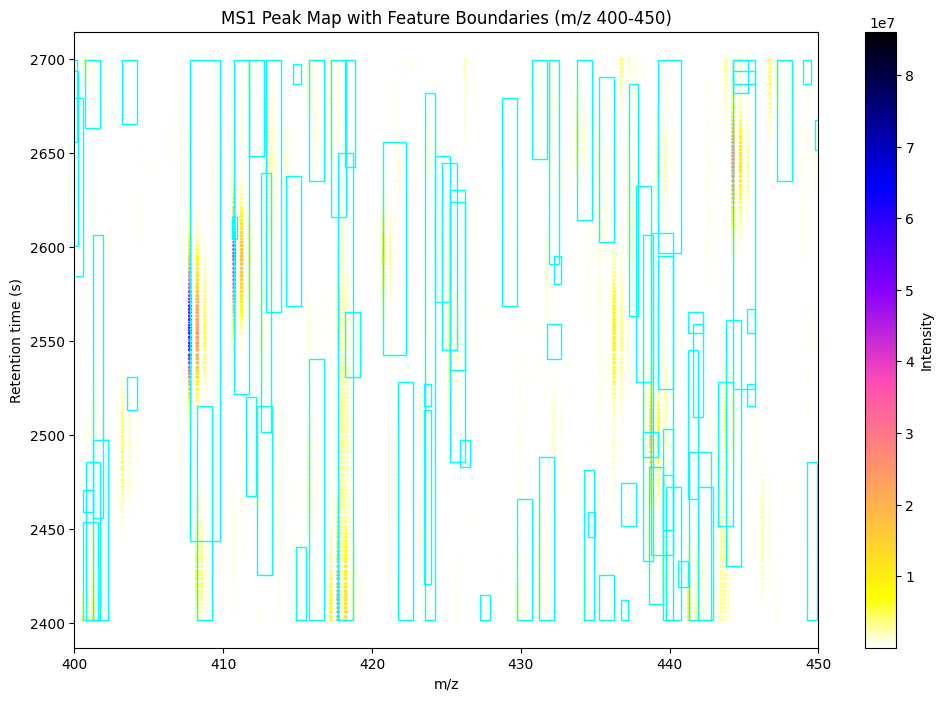

Features overlapping region: 82


In [261]:
# Plot MS1 peak map with feature boundaries (same style as Notebook 1)
# Using the same m/z region (400-450) for comparison
import matplotlib.colors as mpl_colors
import matplotlib.patches as patches

mz_min, mz_max = 400, 450

fig, ax = plt.subplots(figsize=(12, 8))
exp.updateRanges()

# Plot raw MS1 peaks (same as Notebook 1)
for spec in exp:
    if spec.getMSLevel() == 1:
        mz, intensity = spec.get_peaks()
        # Filter to region of interest
        mask = (mz >= mz_min) & (mz <= mz_max)
        mz_filt = mz[mask]
        intensity_filt = intensity[mask]
        if len(mz_filt) > 0:
            p = intensity_filt.argsort()
            rt = np.full(len(mz_filt), spec.getRT())
            ax.scatter(
                mz_filt[p],
                rt[p],
                c=intensity_filt[p],
                s=3,
                cmap="gnuplot2_r",
                norm=mpl_colors.Normalize(exp.getMinIntensity() + 1, exp.getMaxIntensity()),
            )

# Add feature bounding boxes - include features that overlap the visible region
# (not just those with centroids inside)
df_region = df[(df["mz_start"] < mz_max) & (df["mz_end"] > mz_min)]
for _, row in df_region.iterrows():
    rect = patches.Rectangle(
        (row["mz_start"], row["rt_start"]),
        row["mz_end"] - row["mz_start"],
        row["rt_end"] - row["rt_start"],
        linewidth=1,
        edgecolor='cyan',
        facecolor='none'
    )
    ax.add_patch(rect)

ax.set_xlim(mz_min, mz_max)
ax.set_xlabel("m/z")
ax.set_ylabel("Retention time (s)")
plt.colorbar(ax.collections[0], label="Intensity")
plt.title(f"MS1 Peak Map with Feature Boundaries (m/z {mz_min}-{mz_max})")
plt.show()

print(f"Features overlapping region: {len(df_region)}")

### 3D Feature Visualization

We can create an interactive 3D visualization to explore the raw MS1 peaks within a detected feature. This shows how the peptide signal builds up across retention time and reveals the isotope pattern in the m/z dimension.

Below we visualize a high-intensity feature (RT 2557s, m/z 407.8, charge +2) with its bounding box expanded by 1.3x for context.

In [262]:
# Visualize raw MS1 peaks for a high-intensity feature
# Feature at RT 2557s, m/z 407.76 (charge +2, intensity 59.4M)
# Bounding box expanded by 1.3x for context
rt_min, rt_max = 2405.0, 2737.8
mz_min, mz_max = 407.45, 410.06

# Actual feature boundaries (for rectangle overlay)
feat_rt_start, feat_rt_end = 2443.4, 2699.4
feat_mz_start, feat_mz_end = 407.76, 409.76

print(f"3D region: RT [{rt_min:.0f}, {rt_max:.0f}]s, m/z [{mz_min:.2f}, {mz_max:.2f}]")

# Extract raw MS1 peaks in this region
peaks_3d = []
for spec in exp:
    if spec.getMSLevel() == 1:
        rt = spec.getRT()
        if rt_min <= rt <= rt_max:
            mz_arr, int_arr = spec.get_peaks()
            mask = (mz_arr >= mz_min) & (mz_arr <= mz_max)
            for mz_val, int_val in zip(mz_arr[mask], int_arr[mask]):
                peaks_3d.append({"rt": rt, "mz": mz_val, "intensity": int_val})

df_peaks = pd.DataFrame(peaks_3d)
print(f"Raw MS1 peaks in region: {len(df_peaks)}")

# Create interactive 3D peakmap of raw peaks
pd.options.plotting.backend = "ms_plotly"
fig = df_peaks.plot(
    kind="peakmap",
    x="rt",
    y="mz",
    z="intensity",
    plot_3d=True,
    title="3D view of feature at RT 2557s, m/z 407.8",
    show_plot=False
)

# Add feature boundary as vertical walls (4 sides of the bounding box)
import plotly.graph_objects as go
z_height = df_peaks["intensity"].max() * 0.3  # 30% of max intensity

# Draw 4 vertical walls around the feature boundary
for rt_vals, mz_vals in [
    ([feat_rt_start, feat_rt_start], [feat_mz_start, feat_mz_end]),  # left wall
    ([feat_rt_end, feat_rt_end], [feat_mz_start, feat_mz_end]),      # right wall
    ([feat_rt_start, feat_rt_end], [feat_mz_start, feat_mz_start]),  # front wall
    ([feat_rt_start, feat_rt_end], [feat_mz_end, feat_mz_end]),      # back wall
]:
    fig.add_trace(go.Scatter3d(
        x=rt_vals + rt_vals[::-1] + [rt_vals[0]],
        y=mz_vals + mz_vals[::-1] + [mz_vals[0]],
        z=[0, 0, z_height, z_height, 0],
        mode='lines',
        line=dict(color='cyan', width=4),
        showlegend=False
    ))

fig.show()

3D region: RT [2405, 2738]s, m/z [407.45, 410.06]
Raw MS1 peaks in region: 3435


---

### Exercise 3: Interpret the Feature Map

**Predict first, then verify!** Look at the peak map visualization with feature bounding boxes.

1. **Prediction**: For a single peptide ion, what shape should its feature bounding box have? (tall and narrow, short and wide, or roughly square?)

2. **Observation**: Do you see any features that overlap in m/z? What might this indicate?

3. **Exploration**: Zoom into a region with many features. Can you identify isotope patterns (vertically stacked rectangles spaced by ~0.5 m/z for +2 or ~0.33 m/z for +3)?

<details>
<summary><b>Click to check your predictions</b></summary>

**Answer 1: Feature shape**

Features should be **short and wide** (spans RT, narrow in m/z):
- **RT range**: Peptides elute over 10-60 seconds → wide
- **m/z range**: Includes isotopes (M, M+1, M+2) → narrow (typically <2 Da)

```
m/z ↑
    │  ┌──────────────────┐  ← Short in m/z (isotope envelope)
    │  │                  │
    │  └──────────────────┘  ← Wide in RT (elution time)
    └────────────────────────→ RT
```

**Answer 2: Overlapping features**

Features overlapping in m/z but at different RT are different peptides with similar masses:
- Same peptide eluting multiple times (carryover)
- Isobaric peptides (different sequence, same mass)
- Same peptide from different proteins

Features overlapping in BOTH m/z AND RT might indicate:
- Multiple charge states of the same peptide (should be related by charge: m/z₁ × z₁ ≈ m/z₂ × z₂)
- Co-eluting isobaric peptides (challenging for quantification)

**Answer 3: Isotope patterns**

For a +2 charged peptide, you should see isotope peaks spaced ~0.5 m/z apart:
- Monoisotopic peak (lightest)
- M+1 (+0.5 m/z)
- M+2 (+1.0 m/z)

Each isotope peak is tracked as part of the same feature in Biosaur2's isotope-aware detection.

</details>

---

## Summary

Congratulations! You've completed the proteomics data analysis workflow. Here's what you learned:

| Step | Concept | Key pyOpenMS Tool |
|------|---------|-------------------|
| **Feature detection** | Group MS1 peaks across RT into features | `Biosaur2Algorithm` |
| **Isotope awareness** | Use isotope patterns to infer charge | Built into Biosaur2 |
| **ID mapping** | Link MS2 identifications to MS1 features | `IDMapper` |
| **Tolerance settings** | Account for measurement variability | RT and m/z tolerances |
| **Data export** | Convert to pandas for analysis | `FeatureMap.get_df()` |
| **Visualization** | Interactive peak maps with annotations | `pyopenms_viz` |

---

<details>
<summary><b>Putting It All Together: Complete Workflow Reflection</b></summary>

**Test your understanding of the complete proteomics workflow!**

You've now completed all three notebooks. Think about how they connect:

**Question 1**: A peptide has been identified by database search (Notebook 2) but wasn't found as a feature (Notebook 3). What could explain this?

<details>
<summary>Answer</summary>

Possible explanations:
- Peptide had low MS1 signal (below feature detection threshold)
- MS2 was acquired during co-elution with another peptide (chimeric)
- Feature detection parameters were too strict
- The peptide eluted at the edge of the gradient (poor peak shape)

</details>

**Question 2**: You found a feature with high intensity (Notebook 3) but it has no peptide identification. What could you do to investigate?

<details>
<summary>Answer</summary>

Investigation steps:
- Check if MS2 was acquired for this precursor (DDA might have missed it)
- Look at the m/z - is it in the typical peptide range?
- Check the isotope pattern - does it look like a peptide?
- Consider: could it be a contaminant, lipid, or metabolite?
- Try searching with different modifications or a larger database

</details>

**Question 3**: How do mass tolerances connect across the workflow?

<details>
<summary>Answer</summary>

Mass tolerance appears at multiple stages:
1. **Notebook 2 (Candidate selection)**: Precursor mass ± tolerance → candidate peptides
2. **Notebook 2 (Alignment)**: Fragment m/z ± tolerance → matched ions
3. **Notebook 3 (IDMapper)**: Feature m/z ± tolerance → mapped identifications

These should all be set according to your instrument's accuracy. Inconsistent tolerances can cause problems (e.g., strict ID tolerance but loose feature mapping could mis-assign IDs).

</details>

</details>

---

## Complete Workflow Summary

**The three notebooks covered:**

| Notebook | Topic | Key Steps |
|----------|-------|-----------|
| **Notebook 1** | Raw Data | Protein digestion → LC-MS → Spectra (mzML) |
| **Notebook 2** | Identification | MS2 spectra → Theoretical spectra → Match & Score → PSMs (idXML) |
| **Notebook 3** | Quantification | MS1 spectra → Feature detection → ID mapping → Annotated features |

---

## Bonus Challenges

<details>
<summary><b>Challenge 1 (Beginner): Filter by Quality</b></summary>

Filter the DataFrame to keep only high-quality features:

```python
# Filter features with quality > 5
df_high_quality = df[df['quality'] > 5]
print(f"High quality features: {len(df_high_quality)} / {len(df)}")

# Compare ID rates
original_id_rate = df['peptide_sequence'].notna().mean()
filtered_id_rate = df_high_quality['peptide_sequence'].notna().mean()
print(f"ID rate: {original_id_rate:.1%} → {filtered_id_rate:.1%}")
```

**Question**: Does filtering by quality improve the identification rate?

</details>

<details>
<summary><b>Challenge 2 (Intermediate): Visualize Identified Features with Peptide Sequences</b></summary>

Create a visualization that highlights identified features in green and adds peptide sequence labels. This helps you see which peptides were successfully quantified.

**Task**: Modify the peak map to:
1. Show identified features in green, unidentified in blue
2. Add peptide sequence annotations to identified features

<details>
<summary><b>Click to reveal solution</b></summary>

```python
import plotly.graph_objects as go

# Filter to a region with identified features
df_viz = df[(df["rt"] >= 2450) & (df["rt"] <= 2650) &
            (df["mz"] >= 500) & (df["mz"] <= 900)]

fig = go.Figure()

# Add feature rectangles with color coding
shapes = []
annotations = []

for _, row in df_viz.iterrows():
    has_id = pd.notna(row['peptide_sequence'])
    color = "green" if has_id else "rgba(100,100,255,0.5)"
    width = 2 if has_id else 1
    
    shapes.append(dict(
        type="rect",
        x0=row["rt_start"], x1=row["rt_end"],
        y0=row["mz_start"], y1=row["mz_end"],
        line=dict(color=color, width=width),
        fillcolor="rgba(0,255,0,0.1)" if has_id else "rgba(0,0,0,0)"
    ))
    
    # Add sequence label for identified features
    if has_id:
        seq = row['peptide_sequence']
        # Truncate long sequences
        label = seq if len(seq) <= 12 else seq[:10] + "..."
        annotations.append(dict(
            x=(row["rt_start"] + row["rt_end"]) / 2,
            y=row["mz_end"] + 2,  # Position above the box
            text=f"{label} (+{row['charge']})",
            showarrow=False,
            font=dict(size=8, color="darkgreen"),
            textangle=0
        ))

# Add a scatter trace for the legend
fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
    marker=dict(size=10, color='green'), name='Identified'))
fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
    marker=dict(size=10, color='blue'), name='Unidentified'))

fig.update_layout(
    shapes=shapes,
    annotations=annotations,
    title="Feature Map with Peptide Sequence Labels",
    xaxis_title="Retention Time (s)",
    yaxis_title="m/z",
    width=1200,
    height=900,
    showlegend=True
)

fig.show()
```

**Observations to make:**
- Are identified features clustered in certain RT/m/z regions?
- Do identified features tend to have higher intensities?
- Can you spot the same peptide at different charge states?

</details>

</details>

<details>
<summary><b>Challenge 3 (Advanced): Intensity Distribution Analysis</b></summary>

Analyze whether feature intensity affects identification:

```python
import matplotlib.pyplot as plt

# Split features by identification status
identified = df[df['peptide_sequence'].notna()]['intensity']
unidentified = df[df['peptide_sequence'].isna()]['intensity']

# Plot histograms
plt.figure(figsize=(10, 5))
plt.hist(np.log10(identified), bins=50, alpha=0.5, label='Identified')
plt.hist(np.log10(unidentified), bins=50, alpha=0.5, label='Unidentified')
plt.xlabel('log10(Intensity)')
plt.ylabel('Count')
plt.legend()
plt.title('Intensity Distribution: Identified vs Unidentified Features')
plt.show()
```

**Question**: Are higher-intensity features more likely to be identified? Why?

</details>

<details>
<summary><b>Challenge 4 (Expert): Summarize Peptide Quantities Across Charge States</b></summary>

In proteomics, the same peptide often appears as multiple features with different charge states (+2, +3, etc.). For accurate peptide-level quantification, we need to combine these into a single abundance value per peptide sequence.

**Task**: Group features by peptide sequence and sum their intensities to get peptide-level quantities.

<details>
<summary><b>Click to reveal solution</b></summary>

```python
# Filter to identified features only
identified_df = df[df['peptide_sequence'].notna()].copy()

print(f"Identified features: {len(identified_df)}")
print(f"Unique peptide sequences: {identified_df['peptide_sequence'].nunique()}")

# Group by peptide sequence and aggregate
peptide_quantities = identified_df.groupby('peptide_sequence').agg({
    'intensity': 'sum',           # Sum intensities across charge states
    'charge': lambda x: list(x),  # List all observed charge states
    'rt': 'mean',                 # Average RT (should be similar)
    'mz': 'first',                # Representative m/z
    'quality': 'mean'             # Average quality
}).reset_index()

# Add charge state count
peptide_quantities['n_charge_states'] = peptide_quantities['charge'].apply(len)
peptide_quantities['charge_states'] = peptide_quantities['charge'].apply(
    lambda x: '+' + ', +'.join(map(str, sorted(set(x))))
)

# Sort by intensity (most abundant first)
peptide_quantities = peptide_quantities.sort_values('intensity', ascending=False)

# Display results
print("\nPeptide-level quantities (top 10 by intensity):")
print(peptide_quantities[['peptide_sequence', 'intensity', 'n_charge_states',
                          'charge_states', 'rt']].head(10).to_string(index=False))

# Visualize: peptides with multiple charge states
multi_charge = peptide_quantities[peptide_quantities['n_charge_states'] > 1]
print(f"\nPeptides detected in multiple charge states: {len(multi_charge)}")

# Plot intensity contribution by charge state for a peptide
if len(multi_charge) > 0:
    example_peptide = multi_charge.iloc[0]['peptide_sequence']
    example_features = identified_df[identified_df['peptide_sequence'] == example_peptide]
    
    plt.figure(figsize=(8, 4))
    plt.bar([f"+{c}" for c in example_features['charge']],
            example_features['intensity'])
    plt.xlabel('Charge State')
    plt.ylabel('Feature Intensity')
    plt.title(f'Intensity by Charge State: {example_peptide}')
    plt.show()
    
    print(f"\nExample: {example_peptide}")
    print(f"  Total peptide intensity: {example_features['intensity'].sum():.0f}")
    print(f"  Charge states: {list(example_features['charge'].values)}")
```

**Discussion questions:**
1. What percentage of identified peptides appear in multiple charge states?
2. Does one charge state typically dominate the intensity?
3. Why is summing intensities across charge states important for comparing peptide abundances between samples?

</details>

</details>

---

## What's Next?

You now have the foundation to explore more advanced topics:

- **Label-free quantification (LFQ)**: Compare peptide abundances across samples
- **Isobaric labeling (TMT/iTRAQ)**: Multiplex quantification using reporter ions
- **Data-independent acquisition (DIA)**: Alternative to DDA with better quantification
- **Statistical analysis**: Differential expression between conditions
- **Protein inference**: Roll up peptide quantities to protein level

**Resources:**
- [pyOpenMS Documentation](https://pyopenms.readthedocs.io/)
- [OpenMS Tutorials](https://openms.readthedocs.io/en/latest/tutorials/index.html)

---

**Previous notebooks:** [Notebook 1 - Peaks](EUBIC_Task1_Peaks.ipynb) | [Notebook 2 - Identification](EUBIC_Task2_ID.ipynb)